# CASO DE ESTUDIO 4 - ELIMINACION DE RUIDO EN IMAGENES

## 1. Configuracion inicial

### 1.1 Instalacion de bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import cifar10
from tensorflow.keras.models import Model
import tensorflow as tf

2025-05-07 13:48:59.240568: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746618540.154912   53310 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746618540.387760   53310 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746618542.350116   53310 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746618542.350140   53310 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746618542.350142   53310 computation_placer.cc:177] computation placer alr

### 1.2 Carga del dataset CIFAR-10
`keras.datasets.cifar10.load_data()`

In [2]:
# Punto 2.3 aqui incluido

(x_train, _), (x_test, _) = cifar10.load_data()


### 1.3 Exploracion del dataset

- Visualizar 10 ejemplos de imagenes
- Verificar dimensiones

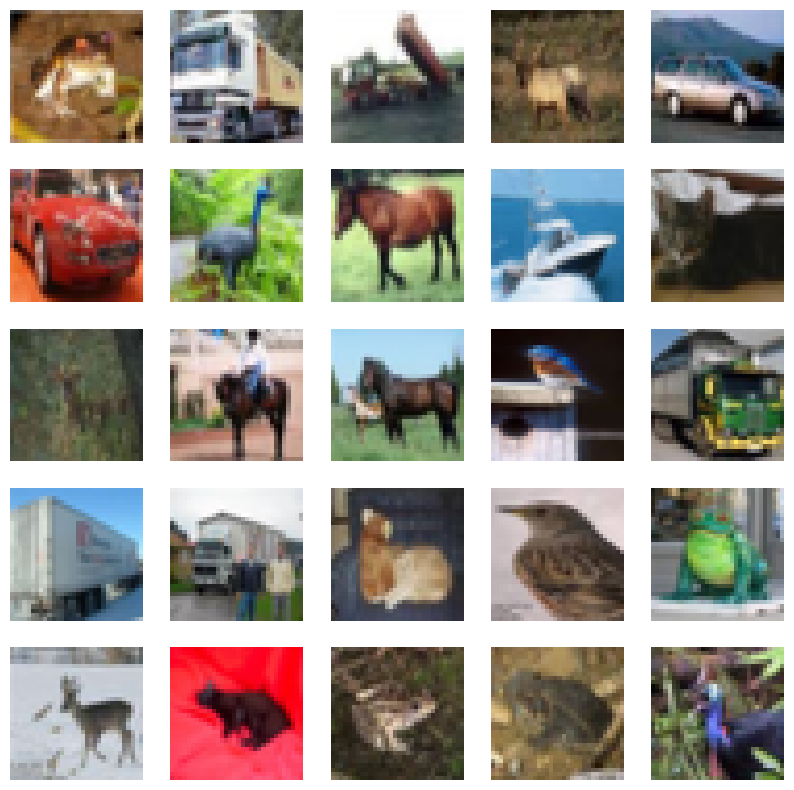

In [3]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(x_train[i], cmap='gray')
    plt.axis('off')
plt.show()

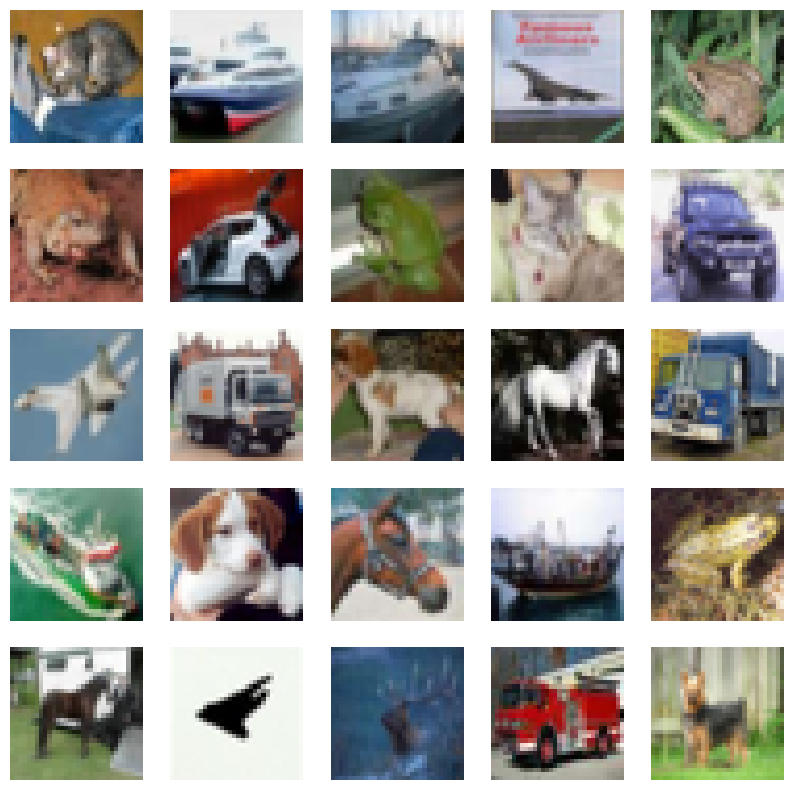

In [4]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(x_test[i], cmap='gray')
    plt.axis('off')
plt.show()

In [5]:
print("Dimensiones de x_train: ", x_train.shape)
print("Dimensiones de x_test: ", x_test.shape)

Dimensiones de x_train:  (50000, 32, 32, 3)
Dimensiones de x_test:  (10000, 32, 32, 3)


## 2. Preparacion de los datos

### 2.1 Normalizar al rango [0, 1]

In [6]:
x_train_normal = x_train / 255.0
x_test_normal = x_test / 255.0

### 2.2 Introduccion de ruido
- Introduccion de ruido Gaussiano (media=0, desviacion estandar=0.1) (`np.random.normal`)
- Clip las imagenes a rango [0, 1] (`np.clip(imagen_con_ruido, 0., 1.)`)

In [7]:
x_train_noise = np.random.normal(x_train_normal)
x_test_noise = np.random.normal(x_test_normal)

print(x_train_noise.shape)
print(x_test_noise.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [8]:
x_train_clip = np.clip(x_train_noise, 0., 1.)
x_test_clip = np.clip(x_test_noise, 0., 1.)

print(x_train_clip.shape)
print(x_test_clip.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


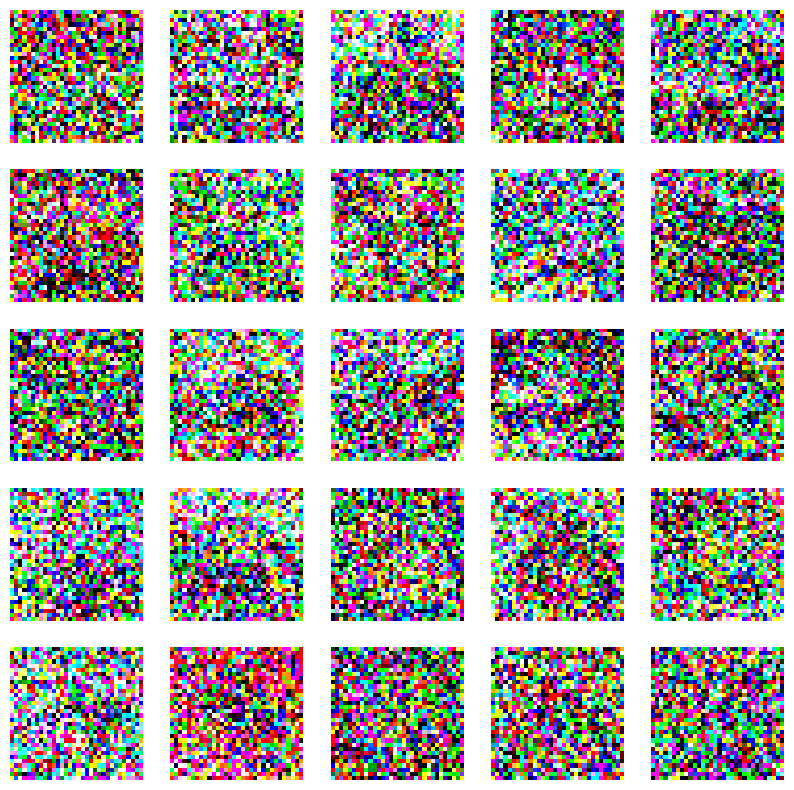

In [9]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(x_train_clip[i], cmap='gray')
    plt.axis('off')
plt.show()

### 2.3 Division de datos
Dividir los datos en entrenamiento (50,000 imágenes) y prueba (10,000 imágenes).

Ya viene pre-dividido por defecto en `keras.datasets.cifar10.load_data()`. No hace falta hacer la separación manual a menos que quieras definir un validation split adicional. Podrías aclarar esto.
```Python
from keras.datasets import cifar10

(x_train, _), (x_test, _) = cifar10.load_data()
```

## 3. Diseño de la Arquitectura
Construir un autoencoder convolucional simetrico

### 3.1 Encoder
- Capas convolucionales (`Conv2D`) con activación ReLU.
- Reducir progresivamente las dimensiones espaciales (ej: 32x32 → 16x16 → 8x8).
- Capa final: "cuello de botella" (espacio latente).

### 3.2 Decoder
- Capas transpuestas (`Conv2DTranspose`) para reconstruir la imagen.
- Usar activación `sigmoid` en la última capa (rango [0, 1]).

In [10]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      tf.keras.layers.Input(shape=(32, 32, 3)),
      tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2),
      tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
      tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

    self.decoder = tf.keras.Sequential([
      tf.keras.layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      tf.keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      tf.keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, activation='relu', padding='same'),
      tf.keras.layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()

I0000 00:00:1746618595.522787   53310 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3586 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [11]:
autoencoder.encoder.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 16, 16, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 16)       │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 8)        │         1,160 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,680 (26.09 KB)

 Trainable params: 6,680 (26.09 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
autoencoder.decoder.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_transpose                │ ?                      │   0 (unbuilt) │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ ?                      │   0 (unbuilt) │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ ?                      │   0 (unbuilt) │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## 4. Entrenamiento del modelo

### 4.1 Compilacion del modelo
- Funcion de perdida: **`MSE`**
- Optimizador: **`Adam`** con **learning rate=0.001**

In [ ]:
autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
    loss=tf.keras.losses.MeanSquaredError()
)

: 

### 4.2 Entrenar con datos ruidosos como entrada y originales como *target*
- Batch size: 64-128
- Epochs: 20-30

In [ ]:
if tf.config.list_physical_devices("GPU"):
    print("Usando GPU :)")
    with tf.device("GPU:0"):
        
        autoencoder.fit(
            x_train_clip, x_train_normal,
            batch_size=64,
            epochs=20,
            shuffle=True,
            validation_data=(x_test_clip, x_test_normal),
            verbose=1
        )
else:
    print("Esto va mal.")

Usando GPU :)


In [ ]:
# encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
# decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

### 4.3 Guardar el modelo entrenado para evaluacion
- Usar ModelCheckpoint para guardar el mejor modelo durante el entrenamiento.

## 5. Evaluacion y visualizacion

### 5.1 Cuantitativa
Calcular el PSNR (Peak Signal-to-Noise Ratio) entre originales y reconstruidas
- Valores altos de PSNR = mayor calidad
- Se calcula como:
```
psnr = 10 * np.log10(1.0 / (mse + 1e-8))
```

### 5.2 Cualitativa
Visualizar ejemplos de:
- Imagen original
- Imagen ruidosa
- Imagen reconstruida

## 6. Analisis critico
Responder a las siguientes preguntas (entre otras posibles):
- ¿En qué tipos de imágenes (ej: animales, vehículos) funciona mejor el modelo?
- ¿Qué ocurre si aumentamos la intensidad del ruido (ej: desviación estándar=0.2)?
- ¿Cómo afectaría añadir más capas al encoder/decoder?
- Propón una modificación para mejorar el modelo (ej: regularización, dropout).

## 7. Entrega final
Reporte breve (1 página) con:
- Descripción de la arquitectura usada (diagrama opcional).
- Gráficos de pérdida durante entrenamiento.
- PSNR promedio en el dataset de prueba.
- Visualización de 5 ejemplos de reconstrucción.